# Finance and Risk Analytics Capstone

### Importing the packages

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet
from pypfopt import EfficientFrontier, risk_models, expected_returns
import ta
from prophet import Prophet


# Data display customization
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the data

#### 1. Aviation Data :

In [2]:
AAL  = pd.read_csv('AAL.csv', parse_dates=['Date'], dayfirst=True)
ALGT = pd.read_csv('ALGT.csv', parse_dates=['Date'], dayfirst=True)
ALK  = pd.read_csv('ALK.csv', parse_dates=['Date'], dayfirst=True)
DAL  = pd.read_csv('DAL.csv', parse_dates=['Date'], dayfirst=True)
HA   = pd.read_csv('HA.csv', parse_dates=['Date'], dayfirst=True)
LUV  = pd.read_csv('LUV.csv', parse_dates=['Date'], dayfirst=True)

#### 2. Finance Data :

In [3]:
BCS  = pd.read_csv('BCS.csv', parse_dates=['Date'], dayfirst=True)
CS   = pd.read_csv('CS.csv', parse_dates=['Date'], dayfirst=True)
DB   = pd.read_csv('DB.csv', parse_dates=['Date'], dayfirst=True)
GS   = pd.read_csv('GS.csv', parse_dates=['Date'], dayfirst=True)
MS   = pd.read_csv('MS.csv', parse_dates=['Date'], dayfirst=True)
WFC  = pd.read_csv('WFC.csv', parse_dates=['Date'], dayfirst=True)

#### 3.  Pharma_Healthcare Data:

In [4]:
BHC   = pd.read_csv('BHC.csv', parse_dates=['Date'], dayfirst=True)
JNJ   = pd.read_csv('JNJ.csv', parse_dates=['Date'], dayfirst=True)
MRK   = pd.read_csv('MRK.csv', parse_dates=['Date'], dayfirst=True)
PFE   = pd.read_csv('PFE.csv', parse_dates=['Date'], dayfirst=True)
RHHBY = pd.read_csv('RHHBY.csv', parse_dates=['Date'], dayfirst=True)
UNH   = pd.read_csv('UNH.csv', parse_dates=['Date'], dayfirst=True)

#### 4. Technology Data:

In [5]:
AAPL  = pd.read_csv('AAPL.csv', parse_dates=['Date'], dayfirst=True)
AMZN  = pd.read_csv('AMZN.csv', parse_dates=['Date'], dayfirst=True)
FB    = pd.read_csv('FB.csv', parse_dates=['Date'], dayfirst=True)
GOOG  = pd.read_csv('GOOG.csv', parse_dates=['Date'], dayfirst=True)
IBM   = pd.read_csv('IBM.csv', parse_dates=['Date'], dayfirst=True)
MSFT  = pd.read_csv('MSFT.csv', parse_dates=['Date'], dayfirst=True)

#### S&P 500 Data:

In [6]:
SP500  = pd.read_csv('S&P500.csv', parse_dates=['Date'], dayfirst=True)

#### Annexure Data:

In [7]:
Annex = pd.read_csv("Annexure-I.csv", delimiter=',', header=None, skiprows=1, names=['Ticker','Industry','Company Name'])

## Merging Stocks to one Dataframe
Closing price of stock is taken as daily stock price

In [8]:
stock_list=[AAL,ALGT,ALK,DAL,HA,LUV,
        BCS,CS,DB,GS,MS,WFC,
        BHC,JNJ,MRK,PFE,RHHBY,UNH,
        AAPL,AMZN,FB,GOOG,IBM,MSFT,
         SP500]

In [9]:
tickers=['AAL','ALGT','ALK','DAL','HA','LUV',
        'BCS','CS','DB','GS','MS','WFC',
        'BHC','JNJ','MRK','PFE','RHHBY','UNH',
        'AAPL','AMZN','FB','GOOG','IBM','MSFT',
         'SP500'
            ]

In [10]:
Stock=[]
for i, name in enumerate(tickers):
    stock_list[i]['Stock']=name
    stock_list[i].set_index('Date', inplace=True)
    temp=stock_list[i]
    Stock.append(temp)

Merging and concatinating all the stocks datasets into one single file.

In [11]:
df = pd.concat(Stock)
df = df.reset_index()
df.head()

Date  Open  High   Low  Close  Adj Close     Volume Stock
0 2010-10-01  9.29  9.39  9.21   9.29   8.758067  3603800.0   AAL
1 2010-10-04  9.24  9.48  9.05   9.12   8.597802  3856800.0   AAL
2 2010-10-05  9.27  9.35  9.15   9.23   8.701504  3896600.0   AAL
3 2010-10-06  9.27  9.40  9.15   9.23   8.701504  3230200.0   AAL
4 2010-10-07  9.30  9.31  9.07   9.24   8.710930  3877700.0   AAL

### Cleaning data:

 - As we only need the closing prices of all the stocks and date for time-series analysis, dropping other columns and creating copy of the dataframe.

 - Saving the new dataframe as df_cleaned.

In [12]:
df = pd.concat(Stock)
df = df.reset_index()
df = df[['Date', 'Close', 'Stock']]
df=df.dropna()
df_cleaned = df.copy()
right=Annex[['Ticker','Industry']]
left=df_cleaned.copy()
df_cleaned=pd.merge(left, right, left_on='Stock', right_on='Ticker', how="outer")
df_cleaned.fillna("SP500", inplace = True) 
df_cleaned.drop(columns=['Ticker'],inplace=True)
df_cleaned.head()

Date Close Stock  Industry
0  2010-10-01 00:00:00  9.29   AAL  Aviation
1  2010-10-04 00:00:00  9.12   AAL  Aviation
2  2010-10-05 00:00:00  9.23   AAL  Aviation
3  2010-10-06 00:00:00  9.23   AAL  Aviation
4  2010-10-07 00:00:00  9.24   AAL  Aviation

#### Checking Datatypes:

In [13]:
df_cleaned.dtypes

Date        object
Close       object
Stock       object
Industry    object
dtype: object

- Changing 'Date' from object to DateTime format

In [14]:
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'],dayfirst=True, errors='coerce')

In [15]:
df_cleaned.dtypes

Date        datetime64[ns]
Close               object
Stock               object
Industry            object
dtype: object

- Changing the format of dataframe for better analysis:

In [16]:
df_cleaned=df.pivot('Date','Stock','Close').reset_index()
df_cleaned

Stock       Date    AAL        AAPL        ALGT        ALK         AMZN  \
0     2010-01-04    NaN         NaN         NaN        NaN          NaN   
1     2010-01-05    NaN         NaN         NaN        NaN          NaN   
2     2010-01-06    NaN         NaN         NaN        NaN          NaN   
3     2010-01-07    NaN         NaN         NaN        NaN          NaN   
4     2010-01-08    NaN         NaN         NaN        NaN          NaN   
...          ...    ...         ...         ...        ...          ...   
2700  2020-09-24  11.77  108.220001  121.500000  35.700001  3019.790039   
2701  2020-09-25  12.29  112.279999  123.760002  36.700001  3095.129883   
2702  2020-09-28  12.76  114.959999  127.110001  37.540001  3174.050049   
2703  2020-09-29  12.25  114.089996  121.089996  36.669998  3144.879883   
2704  2020-09-30  12.29  115.809998  119.800003  36.630001  3148.729980   

Stock        BCS    BHC         CS        DAL         DB          FB  \
0      16.894009    NaN  50.771484        NaN  69.875954         NaN   
1      17.824884    NaN  51.191406        NaN  71.211830         NaN   
2      18.129032    NaN  50.478516        NaN  69.980919         NaN   
3      18.801844    NaN  52.519531        NaN  70.772903         NaN   
4      18.967741    NaN  53.291016        NaN  73.330154         NaN   
...          ...    ...        ...        ...        ...         ...   
2700    4.750000  15.22   9.620000  29.010000   8.110000  249.529999   
2701    4.700000  15.30   9.480000  29.780001   8.000000  254.820007   
2702    4.990000  15.27   9.900000  31.340000   8.430000  256.820007   
2703    4.960000  14.88   9.830000  30.610001   8.270000  261.790009   
2704    5.010000  15.54   9.970000  30.580000   8.400000  261.899994   

Stock         GOOG          GS     HA         IBM         JNJ        LUV  \
0              NaN  173.080002    NaN         NaN         NaN        NaN   
1              NaN  176.139999    NaN         NaN         NaN        NaN   
2              NaN  174.259995    NaN         NaN         NaN        NaN   
3              NaN  177.669998    NaN         NaN         NaN        NaN   
4              NaN  174.309998    NaN         NaN         NaN        NaN   
...            ...         ...    ...         ...         ...        ...   
2700   1428.290039  195.110001  12.40  118.089996  144.669998  36.860001   
2701   1444.959961  194.949997  12.80  118.949997  145.660004  37.099998   
2702   1464.520020  199.070007  13.38  121.730003  147.110001  38.240002   
2703   1469.329956  196.789993  12.86  120.940002  147.059998  37.610001   
2704   1469.599976  200.970001  12.89  121.669998  148.880005  37.500000   

Stock        MRK         MS        MSFT        PFE      RHHBY        SP500  \
0            NaN  30.910000         NaN        NaN        NaN          NaN   
1            NaN  32.040001         NaN        NaN        NaN          NaN   
2            NaN  32.450001         NaN        NaN        NaN          NaN   
3            NaN  32.919998         NaN        NaN        NaN          NaN   
4            NaN  32.250000         NaN        NaN        NaN          NaN   
...          ...        ...         ...        ...        ...          ...   
2700   83.150002  46.610001  203.190002  35.759998  44.700001  3246.590088   
2701   82.930000  47.040001  207.820007  36.049999  44.820000  3298.459961   
2702   82.760002  48.380001  209.440002  36.389999  44.110001  3351.600098   
2703   81.900002  47.240002  207.259995  36.169998  43.369999  3335.469971   
2704   82.949997  48.349998  210.330002  36.700001  42.810001  3363.000000   

Stock         UNH        WFC  
0             NaN  27.320000  
1             NaN  28.070000  
2             NaN  28.110001  
3             NaN  29.129999  
4             NaN  28.860001  
...           ...        ...  
2700   292.660004  23.320000  
2701   302.500000  23.639999  
2702   303.230011  23.820000  
2703   304.149994  23.260000  
2704   311.769989  23.510000  

[2705 rows 

- For portfolio creation, we only need data for the last five years i.e. from 2015 to 2020, we are removing the data prior to 2015.

In [17]:
start_date = '2015-09-30'
end_date = '2020-09-30'

In [18]:
dates = (df_cleaned['Date'] > start_date) & (df_cleaned['Date'] <= end_date)

In [19]:
df_cleaned = df_cleaned.loc[dates]
df_cleaned

Stock       Date        AAL        AAPL        ALGT        ALK         AMZN  \
1446  2015-10-01  39.200001   27.395000  217.979996  80.230003   520.719971   
1447  2015-10-02  38.630001   27.594999  215.589996  79.260002   532.539978   
1448  2015-10-05  40.189999   27.695000  216.059998  80.910004   543.679993   
1449  2015-10-06  38.130001   27.827499  208.600006  74.529999   537.479980   
1450  2015-10-07  39.310001   27.695000  213.839996  75.970001   541.940002   
...          ...        ...         ...         ...        ...          ...   
2700  2020-09-24  11.770000  108.220001  121.500000  35.700001  3019.790039   
2701  2020-09-25  12.290000  112.279999  123.760002  36.700001  3095.129883   
2702  2020-09-28  12.760000  114.959999  127.110001  37.540001  3174.050049   
2703  2020-09-29  12.250000  114.089996  121.089996  36.669998  3144.879883   
2704  2020-09-30  12.290000  115.809998  119.800003  36.630001  3148.729980   

Stock    BCS         BHC         CS        DAL         DB          FB  \
1446   15.01  179.600006  24.090000  45.410000  26.520000   90.949997   
1447   15.39  182.320007  24.639999  44.869999  27.139999   92.070000   
1448   15.60  163.460007  25.160000  46.959999  28.200001   94.010002   
1449   15.55  166.000000  25.379999  45.090000  28.400000   92.800003   
1450   15.73  169.830002  25.320000  45.990002  28.790001   92.400002   
...      ...         ...        ...        ...        ...         ...   
2700    4.75   15.220000   9.620000  29.010000   8.110000  249.529999   
2701    4.70   15.300000   9.480000  29.780001   8.000000  254.820007   
2702    4.99   15.270000   9.900000  31.340000   8.430000  256.820007   
2703    4.96   14.880000   9.830000  30.610001   8.270000  261.790009   
2704    5.01   15.540000   9.970000  30.580000   8.400000  261.899994   

Stock         GOOG          GS         HA         IBM         JNJ        LUV  \
1446    611.289978  176.020004  24.730000  143.589996   93.169998  38.410000   
1447    626.909973  177.009995  24.280001  144.580002   93.930000  38.380001   
1448    641.469971  180.699997  25.500000  149.039993   94.760002  39.299999   
1449    645.440002  180.320007  24.250000  148.779999   93.419998  38.000000   
1450    642.359985  182.229996  24.559999  150.089996   94.980003  38.709999   
...            ...         ...        ...         ...         ...        ...   
2700   1428.290039  195.110001  12.400000  118.089996  144.669998  36.860001   
2701   1444.959961  194.949997  12.800000  118.949997  145.660004  37.099998   
2702   1464.520020  199.070007  13.380000  121.730003  147.110001  38.240002   
2703   1469.329956  196.789993  12.860000  120.940002  147.059998  37.610001   
2704   1469.599976  200.970001  12.890000  121.669998  148.880005  37.500000   

Stock        MRK         MS        MSFT        PFE      RHHBY        SP500  \
1446   49.369999  31.500000   44.610001  31.840000  33.220001  1923.819946   
1447   50.139999  31.430000   45.570000  33.080002  33.320000  1951.359985   
1448   51.230000  32.290001   46.630001  33.480000  33.439999  1987.050049   
1449   49.799999  32.360001   46.750000  32.790001  33.529999  1979.920044   
1450   50.950001  32.930000   46.799999  33.290001  32.549999  1995.829956   
...          ...        ...         ...        ...        ...          ...   
2700   83.150002  46.610001  203.190002  35.759998  44.700001  3246.590088   
2701   82.930000  47.040001  207.820007  36.049999  44.820000  3298.459961   
2702   82.760002  48.380001  209.440002  36.389999  44.110001  3351.600098   
2703   81.900002  47.240002  207.259995  36.169998  43.369999  3335.469971   
2704   82.949997  48.349998  210.330002  36.700001  42.810001  3363.000000   

Stock         UNH        WFC  
1446   116.610001  51.439999  
1447   118.830002  51.259998  
1448   119.650002  52.410000  
1449   116.050003  52.029999  
1450   116.430000  52.189999  
...           ...        ...  
2700   292.660004  23.320000  
2701   302.500000  23.639999

- Checking for null values

In [20]:
df_cleaned.isnull().sum()/len(df_cleaned)*100

Stock
Date     0.0
AAL      0.0
AAPL     0.0
ALGT     0.0
ALK      0.0
AMZN     0.0
BCS      0.0
BHC      0.0
CS       0.0
DAL      0.0
DB       0.0
FB       0.0
GOOG     0.0
GS       0.0
HA       0.0
IBM      0.0
JNJ      0.0
LUV      0.0
MRK      0.0
MS       0.0
MSFT     0.0
PFE      0.0
RHHBY    0.0
SP500    0.0
UNH      0.0
WFC      0.0
dtype: float64

In [21]:
#Calculating Null values
df_cleaned.isnull().sum()


Stock
Date     0
AAL      0
AAPL     0
ALGT     0
ALK      0
AMZN     0
BCS      0
BHC      0
CS       0
DAL      0
DB       0
FB       0
GOOG     0
GS       0
HA       0
IBM      0
JNJ      0
LUV      0
MRK      0
MS       0
MSFT     0
PFE      0
RHHBY    0
SP500    0
UNH      0
WFC      0
dtype: int64

- There are no missing values in data

#### Preparing final data:

In [22]:
SP500 = df_cleaned['SP500']
df_cleaned.drop(labels=['SP500'], axis=1,inplace = True)
df_cleaned.insert(1, 'SP500', SP500)
df_cleaned

Stock       Date        SP500        AAL        AAPL        ALGT        ALK  \
1446  2015-10-01  1923.819946  39.200001   27.395000  217.979996  80.230003   
1447  2015-10-02  1951.359985  38.630001   27.594999  215.589996  79.260002   
1448  2015-10-05  1987.050049  40.189999   27.695000  216.059998  80.910004   
1449  2015-10-06  1979.920044  38.130001   27.827499  208.600006  74.529999   
1450  2015-10-07  1995.829956  39.310001   27.695000  213.839996  75.970001   
...          ...          ...        ...         ...         ...        ...   
2700  2020-09-24  3246.590088  11.770000  108.220001  121.500000  35.700001   
2701  2020-09-25  3298.459961  12.290000  112.279999  123.760002  36.700001   
2702  2020-09-28  3351.600098  12.760000  114.959999  127.110001  37.540001   
2703  2020-09-29  3335.469971  12.250000  114.089996  121.089996  36.669998   
2704  2020-09-30  3363.000000  12.290000  115.809998  119.800003  36.630001   

Stock         AMZN    BCS         BHC         CS        DAL         DB  \
1446    520.719971  15.01  179.600006  24.090000  45.410000  26.520000   
1447    532.539978  15.39  182.320007  24.639999  44.869999  27.139999   
1448    543.679993  15.60  163.460007  25.160000  46.959999  28.200001   
1449    537.479980  15.55  166.000000  25.379999  45.090000  28.400000   
1450    541.940002  15.73  169.830002  25.320000  45.990002  28.790001   
...            ...    ...         ...        ...        ...        ...   
2700   3019.790039   4.75   15.220000   9.620000  29.010000   8.110000   
2701   3095.129883   4.70   15.300000   9.480000  29.780001   8.000000   
2702   3174.050049   4.99   15.270000   9.900000  31.340000   8.430000   
2703   3144.879883   4.96   14.880000   9.830000  30.610001   8.270000   
2704   3148.729980   5.01   15.540000   9.970000  30.580000   8.400000   

Stock          FB         GOOG          GS         HA         IBM         JNJ  \
1446    90.949997   611.289978  176.020004  24.730000  143.589996   93.169998   
1447    92.070000   626.909973  177.009995  24.280001  144.580002   93.930000   
1448    94.010002   641.469971  180.699997  25.500000  149.039993   94.760002   
1449    92.800003   645.440002  180.320007  24.250000  148.779999   93.419998   
1450    92.400002   642.359985  182.229996  24.559999  150.089996   94.980003   
...           ...          ...         ...        ...         ...         ...   
2700   249.529999  1428.290039  195.110001  12.400000  118.089996  144.669998   
2701   254.820007  1444.959961  194.949997  12.800000  118.949997  145.660004   
2702   256.820007  1464.520020  199.070007  13.380000  121.730003  147.110001   
2703   261.790009  1469.329956  196.789993  12.860000  120.940002  147.059998   
2704   261.899994  1469.599976  200.970001  12.890000  121.669998  148.880005   

Stock        LUV        MRK         MS        MSFT        PFE      RHHBY  \
1446   38.410000  49.369999  31.500000   44.610001  31.840000  33.220001   
1447   38.380001  50.139999  31.430000   45.570000  33.080002  33.320000   
1448   39.299999  51.230000  32.290001   46.630001  33.480000  33.439999   
1449   38.000000  49.799999  32.360001   46.750000  32.790001  33.529999   
1450   38.709999  50.950001  32.930000   46.799999  33.290001  32.549999   
...          ...        ...        ...         ...        ...        ...   
2700   36.860001  83.150002  46.610001  203.190002  35.759998  44.700001   
2701   37.099998  82.930000  47.040001  207.820007  36.049999  44.820000   
2702   38.240002  82.760002  48.380001  209.440002  36.389999  44.110001   
2703   37.610001  81.900002  47.240002  207.259995  36.169998  43.369999   
2704   37.500000  82.949997  48.349998  210.330002  36.700001  42.810001   

Stock         UNH        WFC  
1446   116.610001  51.439999  
1447   118.830002  51.259998  
1448   119.650002  52.410000  
1449   116.050003  52.029999  
1450   116.430000  52.189999  
...           ...        ...  
2700   292.660004  23.320000  
2701   302.500000  23.639999

In [23]:
df_cleaned.set_index('Date')
df_cleaned.head()

Stock       Date        SP500        AAL       AAPL        ALGT        ALK  \
1446  2015-10-01  1923.819946  39.200001  27.395000  217.979996  80.230003   
1447  2015-10-02  1951.359985  38.630001  27.594999  215.589996  79.260002   
1448  2015-10-05  1987.050049  40.189999  27.695000  216.059998  80.910004   
1449  2015-10-06  1979.920044  38.130001  27.827499  208.600006  74.529999   
1450  2015-10-07  1995.829956  39.310001  27.695000  213.839996  75.970001   

Stock        AMZN    BCS         BHC         CS        DAL         DB  \
1446   520.719971  15.01  179.600006  24.090000  45.410000  26.520000   
1447   532.539978  15.39  182.320007  24.639999  44.869999  27.139999   
1448   543.679993  15.60  163.460007  25.160000  46.959999  28.200001   
1449   537.479980  15.55  166.000000  25.379999  45.090000  28.400000   
1450   541.940002  15.73  169.830002  25.320000  45.990002  28.790001   

Stock         FB        GOOG          GS         HA         IBM        JNJ  \
1446   90.949997  611.289978  176.020004  24.730000  143.589996  93.169998   
1447   92.070000  626.909973  177.009995  24.280001  144.580002  93.930000   
1448   94.010002  641.469971  180.699997  25.500000  149.039993  94.760002   
1449   92.800003  645.440002  180.320007  24.250000  148.779999  93.419998   
1450   92.400002  642.359985  182.229996  24.559999  150.089996  94.980003   

Stock        LUV        MRK         MS       MSFT        PFE      RHHBY  \
1446   38.410000  49.369999  31.500000  44.610001  31.840000  33.220001   
1447   38.380001  50.139999  31.430000  45.570000  33.080002  33.320000   
1448   39.299999  51.230000  32.290001  46.630001  33.480000  33.439999   
1449   38.000000  49.799999  32.360001  46.750000  32.790001  33.529999   
1450   38.709999  50.950001  32.930000  46.799999  33.290001  32.549999   

Stock         UNH        WFC  
1446   116.610001  51.439999  
1447   118.830002  51.259998  
1448   119.650002  52.410000  
1449   116.050003  52.029999  
1450   116.430000  52.189999

### Extracting the final cleaned data in CSV format

In [24]:
df_final = df_cleaned
df_final.to_csv('Final_data.csv',index=False)

In [25]:
df=pd.read_csv('Final_data.csv')

### Visualizing Actual Stock values:

In [26]:
def multi_plot(df, addAll = True):
    fig = go.Figure()

    for column in df.columns.to_list()[1:]:
        fig.add_trace(
            go.Scatter(
                x = df.Date,
                y = df[column],
                name = column
            )
        )

    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns[1:].isin(df.columns.to_list()[1:]),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns[1:].isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = ([button_all] * addAll) + list(df.columns[1:].map(lambda column: create_layout_button(column)))
            )
        ])
    
    fig.update_layout(title_text="Visualizing Actual Stock Values",
                  xaxis_rangeslider_visible=True)
    fig.show()

multi_plot(df)

- The above visualization illustrates the performance of all stocks over a five-year period:
- Amazon's stock prices have seen the most substantial growth, rising approximately 300% compared to the S&P 500 index.
- Google's stock prices have also experienced notable growth, increasing from a base price of 645 to a final price of around 1470, which is approximately 150%.
- All stocks experienced a decline during the COVID-19 phase in 2020.

### Normalized data :

 - Comparing the prices of all stocks to their price on the initial day, October 1, 2015, to observe their variance from the starting price.

In [27]:
from sklearn.preprocessing import MinMaxScaler

df_normalized=df.copy()
scaler = MinMaxScaler()
scaled =scaler.fit_transform(df_normalized.iloc[:,1:])
df_normalized.iloc[:,1:]=scaled

In [28]:
def multi_plot(df, addAll = True):
    fig = go.Figure()

    for column in df.columns.to_list()[1:]:
        fig.add_trace(
            go.Scatter(
                x = df.Date,
                y = df[column],
                name = column
            )
        )

    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns[1:].isin(df.columns.to_list()[1:]),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns[1:].isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = ([button_all] * addAll) + list(df.columns[1:].map(lambda column: create_layout_button(column)))
            
        )
        ])
    
    fig.update_layout(title_text="Visualizing Normalized Stock Values",
                  xaxis_rangeslider_visible=True)
    fig.show()

multi_plot(df_normalized)

- Stocks with values reaching 1 indicate that the companies have performed well and overall achieved profit compared to their initial stock prices.

### Daily Returns

Calculating the daily performance of stocks in comparison to the previous day.

In [29]:
#calculating daily returns
daily_returns=df.copy()

for i in list(daily_returns.columns[1:]):
    daily_returns[i]=daily_returns[i].pct_change(1)

In [30]:
def multi_plot(df, addAll = True):
    fig = go.Figure()

    for column in df.columns.to_list()[1:]:
        fig.add_trace(
            go.Scatter(
                x = df.Date,
                y = df[column],
                name = column
            )
            
        )

    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns[1:].isin(df.columns.to_list()[1:]),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns[1:].isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = ([button_all] * addAll) + list(df.columns[1:].map(lambda column: create_layout_button(column)))
            )
        ])
    
    fig.update_layout(title_text="Visualizing Daily Returns",
                  xaxis_rangeslider_visible=True)
    fig.show()

multi_plot(daily_returns)

- The graph above illustrates the performance of the stocks.
- A positive mean indicates that the stock has been profitable over the years, while negative stock prices indicate losses.

### Checking daily returns statistics for all companies

In [31]:
daily_returns.describe()

SP500          AAL         AAPL         ALGT          ALK  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean      0.000517    -0.000336     0.001322    -0.000047    -0.000256   
std       0.012080     0.034725     0.018729     0.029101     0.026907   
min      -0.119841    -0.252246    -0.128647    -0.283300    -0.232385   
25%      -0.002938    -0.013623    -0.006179    -0.011305    -0.010721   
50%       0.000682    -0.000480     0.000951    -0.000363     0.000206   
75%       0.005213     0.013233     0.009911     0.011630     0.010619   
max       0.093828     0.410970     0.119808     0.292428     0.203079   

              AMZN          BCS          BHC           CS          DAL  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean      0.001611    -0.000548    -0.000897    -0.000437     0.000042   
std       0.018969     0.025119     0.044551     0.022842     0.026478   
min      -0.079221    -0.218519    -0.514629    -0.182598    -0.259924   
25%      -0.006716    -0.010787    -0.019678    -0.010442    -0.009714   
50%       0.001636     0.000000    -0.000501     0.000000     0.000783   
75%       0.010765     0.010215     0.018022     0.010416     0.009781   
max       0.132164     0.151042     0.337444     0.163447     0.210171   

                DB           FB         GOOG           GS           HA  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean     -0.000529     0.001050     0.000834     0.000303     0.000034   
std       0.027743     0.020354     0.016520     0.019899     0.033132   
min      -0.174888    -0.189609    -0.111008    -0.127053    -0.264971   
25%      -0.014976    -0.007223    -0.005788    -0.008386    -0.014908   
50%      -0.001051     0.001193     0.000973     0.000299     0.000342   
75%       0.013872     0.010880     0.008785     0.009704     0.015078   
max       0.140244     0.155214     0.104485     0.175803     0.245837   

               IBM          JNJ          LUV          MRK           MS  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean     -0.000002     0.000451     0.000245     0.000511     0.000578   
std       0.016086     0.012459     0.022913     0.014067     0.021810   
min      -0.128507    -0.100379    -0.151094    -0.088990    -0.156000   
25%      -0.006498    -0.004277    -0.009222    -0.006240    -0.009023   
50%       0.000483     0.000493     0.000618     0.000245     0.000445   
75%       0.006879     0.005921     0.009990     0.007616     0.010451   
max       0.113011     0.079977     0.144441     0.104080     0.197700   

              MSFT          PFE        RHHBY          UNH          WFC  
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000  
mean      0.001387     0.000209     0.000293     0.000941    -0.000414  
std       0.017539     0.013826     0.013514     0.017810     0.020349  
min      -0.147390    -0.077346    -0.089609    -0.172769    -0.158676  
25%      -0.005893    -0.005856    -0.006237    -0.006644    -0.007917  
50%       0.001225     0.000115     0.000229     0.000809    -0.000362  
75%       0.009161     0.006372     0.006919     0.008161     0.007589  
max       0.142169     0.089607     0.130118     0.127989     0.145347

### Calculating the mean and Standard deviation of all the stock prices

In [32]:
daily_returns.describe()[1:3].T.sort_values('mean')

mean       std
BHC   -0.000897  0.044551
BCS   -0.000548  0.025119
DB    -0.000529  0.027743
CS    -0.000437  0.022842
WFC   -0.000414  0.020349
AAL   -0.000336  0.034725
ALK   -0.000256  0.026907
ALGT  -0.000047  0.029101
IBM   -0.000002  0.016086
HA     0.000034  0.033132
DAL    0.000042  0.026478
PFE    0.000209  0.013826
LUV    0.000245  0.022913
RHHBY  0.000293  0.013514
GS     0.000303  0.019899
JNJ    0.000451  0.012459
MRK    0.000511  0.014067
SP500  0.000517  0.012080
MS     0.000578  0.021810
GOOG   0.000834  0.016520
UNH    0.000941  0.017810
FB     0.001050  0.020354
AAPL   0.001322  0.018729
MSFT   0.001387  0.017539
AMZN   0.001611  0.018969

Mean depicts the profit returns by the company whereas Standard Deviation depicts how much risk is associated it.
 - Below mentioned stocks have shown profits is descending order Amazon being the highets and Hawaiian Holdings Inc being the least profitable:
   - AMZN
   - MSFT
   - AAPL
   - FB
   - UNH
   - GOOG
   - MS
   - MRK
   - JNJ
   - GS
   - RHHBY
   - LUV
   - PFE
   - DAL
   - HA

   - Below mentioned stocks have shown risk arranged in ascending order where Johnson & Johnson has least risk associated and Hawaiian Holdings Inc has highest risk:
        - JNJ
        - RHHBY
        - PFE
        - MRK
        - GOOG
        - MSFT
        - UNH
        - AAPL
        - AMZN
        - GS
        - FB
        - MS
        - LUV
        - DAL
        - HA

### Stock Price Dispersion from Mean (Represented using Histogram)

This graph also illustrates the risk associated with the stocks.

In [33]:
def multi_plot(df, addAll = True):
    fig = go.Figure()

    for column in df.columns.to_list()[1:]:
        fig.add_trace(
            go.Histogram(
                x = df[column],
                name = column
            )
            
        )

    button_all = dict(label = 'All',
                      method = 'update',
                      args = [{'visible': df.columns[1:].isin(df.columns.to_list()[1:]),
                               'title': 'All',
                               'showlegend':True}])

    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': df.columns[1:].isin([column]),
                             'title': column,
                             'showlegend': True}])

    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            buttons = ([button_all] * addAll) + list(df.columns[1:].map(lambda column: create_layout_button(column)))
            )
        ])
    
    fig.update_layout(title_text="Stock Price Dispersion from Mean",
                  xaxis_rangeslider_visible=True)
    fig.show()

multi_plot(daily_returns)

This histogram can be utilized to assess the risk and volatility of a stock. Greater dispersion in the histogram indicates higher volatility or, in other words, greater risk associated with the stock.

### Correlation Analysis of Daily Returns

In [34]:
#finding correlation
corr_df = daily_returns.corr(method='pearson')

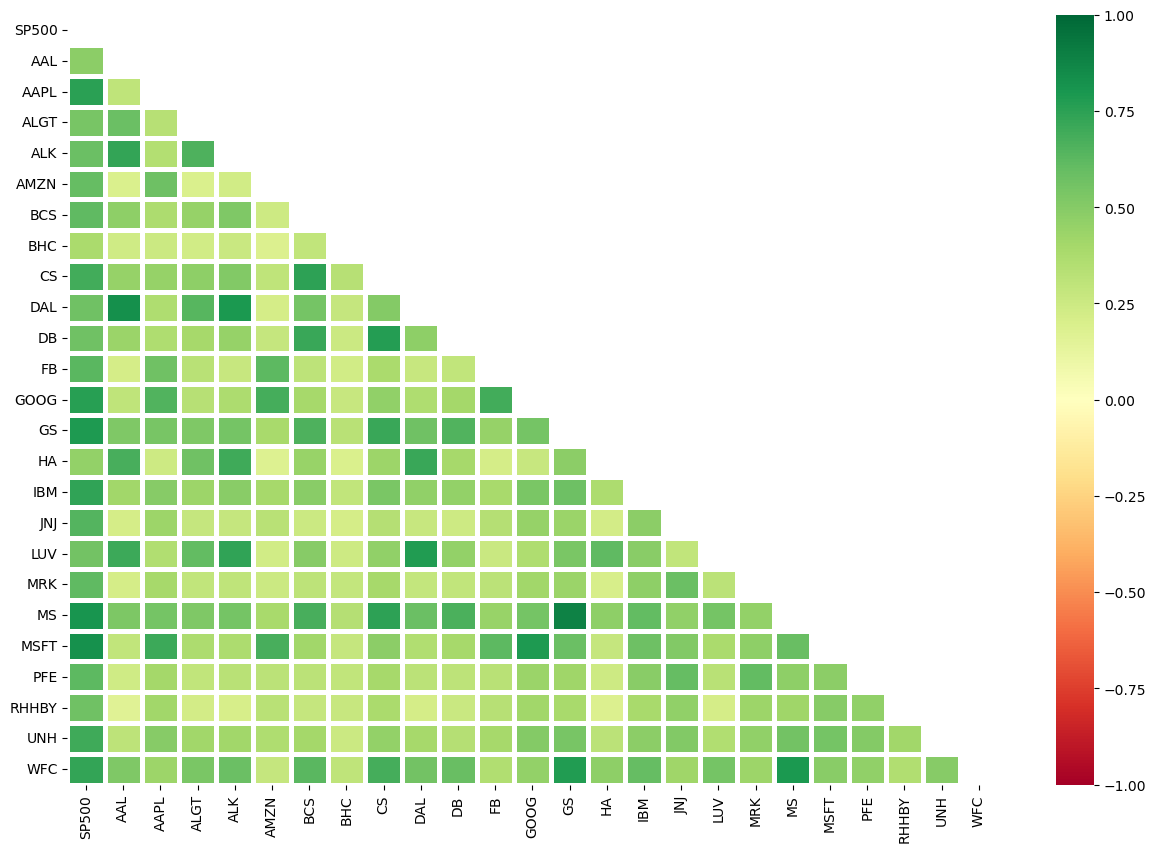

In [35]:
#plotting in a heatmap
plt.figure(figsize=(15,10))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

- The chart above illustrates the correlation between different company stocks, which will assist us in constructing portfolios for our clients.

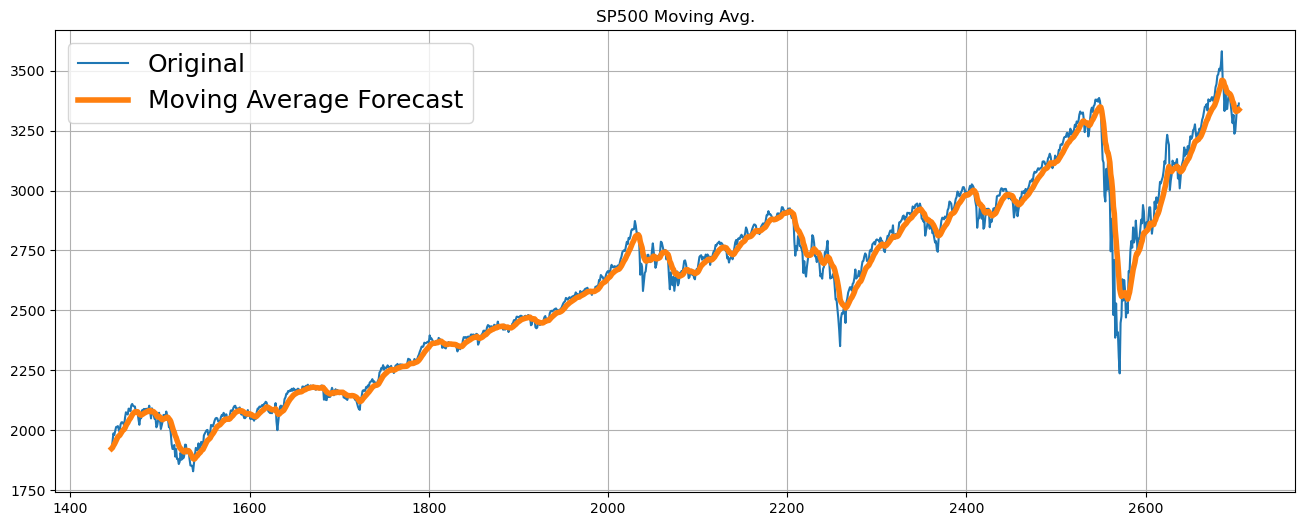

In [36]:
# 14-day moving average
select_stock = 'SP500'
y_hat_avg = df_final.copy()
y_hat_avg['moving_avg_forecast'] = df_final[select_stock].ewm(span=14, adjust=False).mean()

# Plot moving average
plt.figure(figsize=(16,6))
plt.plot(df_final[select_stock], label='Original')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast', linewidth=4)
plt.title(select_stock + " Moving Avg.")
plt.grid(True)
plt.legend(loc='best', fontsize=18)
plt.show()

 - The 14 day forecast shows a very similar trend to sp500 trend showing that we can rely on this for future investments.

# Moving Average

In [37]:
fig = go.Figure()

for column in [select_stock, 'moving_avg_forecast',]:
        fig.add_trace(
            go.Scatter(
                x = y_hat_avg.Date,
                y = y_hat_avg[column],
                name = column
            )
            
        )
fig.update_layout(title_text="Moving Average",
                  xaxis_rangeslider_visible=True)
    
fig.show()

 - The moving forecast of our trend has shown an exact similar pattern as S&P500 for the past five years.
     As our initial assumption that the stocks will perform in the same way for the next five years as it has done in the last five years, now we will study about our clients and give them the portfolio according to their goals and risk appetite.

### Applying ARIMA Model to forecast the stocks 

In [38]:
## Test train split
train = df[:900]
test = df[900:]

In [39]:
## Preparing data in Prophet format
train_prophet = train.rename(columns={'Date': 'ds', 'SP500': 'y'})
test_prophet = test.rename(columns={'Date': 'ds', 'SP500': 'y'})


In [40]:
## Fitting Prophet model
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [41]:
##Make future predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

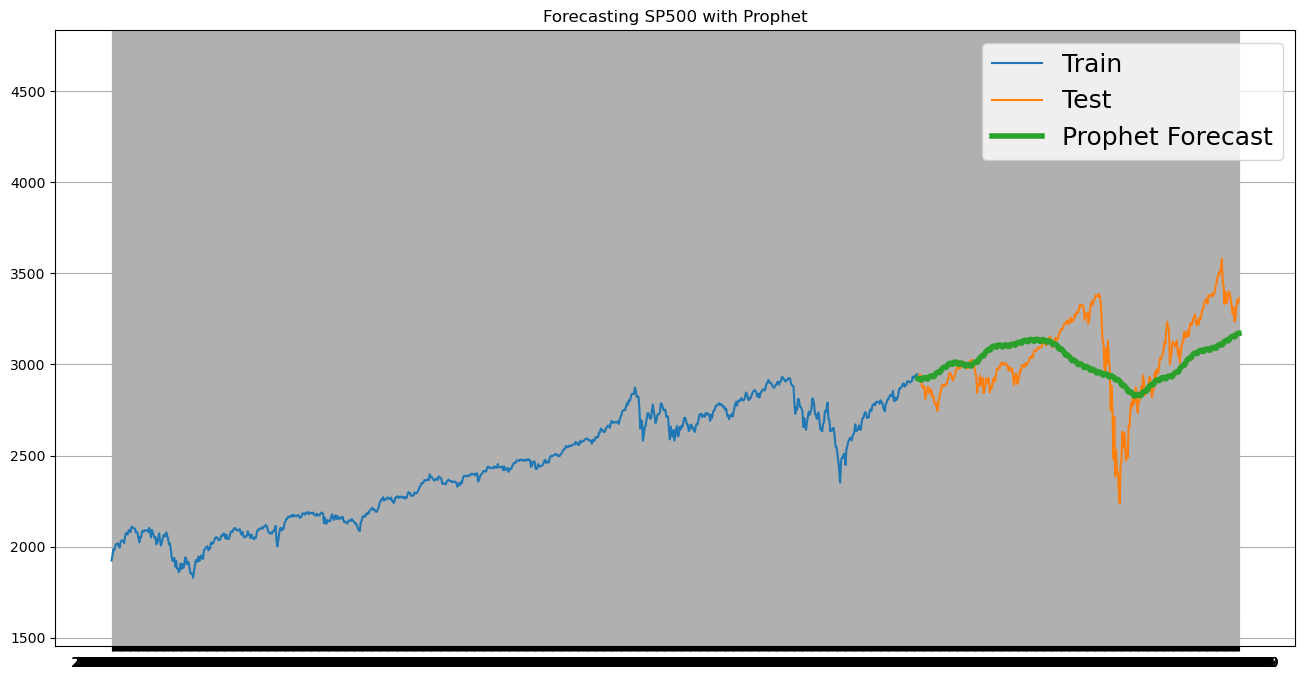

In [42]:
##Plotting the results
plt.figure(figsize=(16, 8))
plt.plot(train['Date'], train['SP500'], label='Train')
plt.plot(test['Date'], test['SP500'], label='Test')
plt.plot(test['Date'], forecast['yhat'][-len(test):], label='Prophet Forecast', linewidth=4)
plt.fill_between(test['Date'].values, y1=forecast['yhat_lower'][-len(test):], y2=forecast['yhat_upper'][-len(test):], alpha=0.4, color='green')
plt.grid(True)
plt.title('Forecasting SP500 with Prophet')
plt.legend(loc='best', fontsize=18)
plt.show()

### Selecting Portfolio

There is a trade off between portfolio risk and return. Therefore by looking at the profiles above we decide the stocks that may be suitable for each investor based on the dispersion/volitility we looked before. 


# Client Profile: Mr. Patrick Jyenger

- Mr. Patrick Jyenger is a conservative investor focused on maintaining a decent standard of living.

- He plans to invest 500,000 dollars for a minority stake and the remaining 500,000 dollars in equities.

- His primary goal is to double his capital with minimal risk over a period of 5 years.

### Portfolio Details:

- We have selected stocks from Microsoft, Merck & Co. Inc., Johnson & Johnson, and Roche Holding AG, all of which have demonstrated favorable returns with relatively low risk.

- The portfolio allocation is as follows: 22.5% in Microsoft, 20% in Merck & Co., 27.5% in Johnson & Johnson, and 30% in Roche Holding AG.

- This selection ensures sector diversification with two stocks from the Healthcare industry, one from Technology, and one from Pharmaceuticals, aiming to reduce overall portfolio volatility.

In [43]:
# Normalize Data
def normalize(df):
    x = df.copy()
    for i in x.columns:
        x[i] = x[i] / x[i][0]
    return x

In [74]:
# Portfolio Allocation
def portfolio_allocation(df, tickers, weights, initial_investment =500000):
    df_portfolio = df[tickers].copy()
    
    # Normalize the stock values 
    df_portfolio = normalize(df_portfolio)
    
    for counter, stock in enumerate(df_portfolio.columns):
        df_portfolio[stock] = df_portfolio[stock] * weights[counter] * 500000

    df_portfolio['Portfolio Daily Value in $'] = df_portfolio.sum(axis=1)
    
    df_portfolio['portfolio daily % return'] = df_portfolio['Portfolio Daily Value in $'].pct_change() * 100
    df_portfolio['portfolio daily % return'].iloc[0] = 0  # Set the first row to zero
    
    return df_portfolio

port1 = ['MSFT','MRK','JNJ','RHHBY']
weights = np.array([0.25, 0.25, 0.25, 0.25, 0.25])
portn = portfolio_allocation(df, port1, weights)
print(portn.head())

            MSFT            MRK            JNJ          RHHBY  \
0  125000.000000  125000.000000  125000.000000  125000.000000   
1  127689.976963  126949.564552  126019.644221  125376.275576   
2  130660.165755  129709.340282  127133.202793  125827.807019   
3  130996.410424  126088.717867  125335.408400  126166.458424   
4  131136.510734  129000.410249  127428.363527  122478.920907   

   Portfolio Daily Value in $  portfolio daily % return  
0               500000.000000                  0.000000  
1               506035.461311                  1.207092  
2               513330.515849                  1.441609  
3               508586.995115                 -0.924068  
4               510044.205418                  0.286521  


In [45]:
# Calculate 5-Year Return
def calculate_5_year_return(df):
    cumulative_return = (df['Portfolio Daily Value in $'].iloc[-1] / df['Portfolio Daily Value in $'].iloc[0]) - 1
    return cumulative_return

five_year_return = calculate_5_year_return(portn)
print(f"5-Year Cumulative Return: {five_year_return * 100:.2f}%")

5-Year Cumulative Return: 132.04%


In [46]:
# Calculate Total Portfolio Value after 5 Years
total_portfolio_value = portn['Portfolio Daily Value in $'].iloc[-1]
print(f"Total Portfolio Value after 5 Years: ${total_portfolio_value:.2f}")

Total Portfolio Value after 5 Years: $1160206.63


In [47]:
# Calculate Volatility
def calculate_volatility(df):
    daily_returns = df['portfolio daily % return'] / 100
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    return annualized_volatility

volatility = calculate_volatility(portn)
print(f"Annualized Volatility: {volatility:.2f}")

Annualized Volatility: 0.19


In [48]:
# Calculate Sharpe Ratio
def calculate_sharpe_ratio(df, risk_free_rate=0.0075):
    daily_returns = df['portfolio daily % return'] / 100
    excess_returns = daily_returns - (risk_free_rate / 252)
    sharpe_ratio = excess_returns.mean() / daily_returns.std() * np.sqrt(252)
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(portn)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 0.93


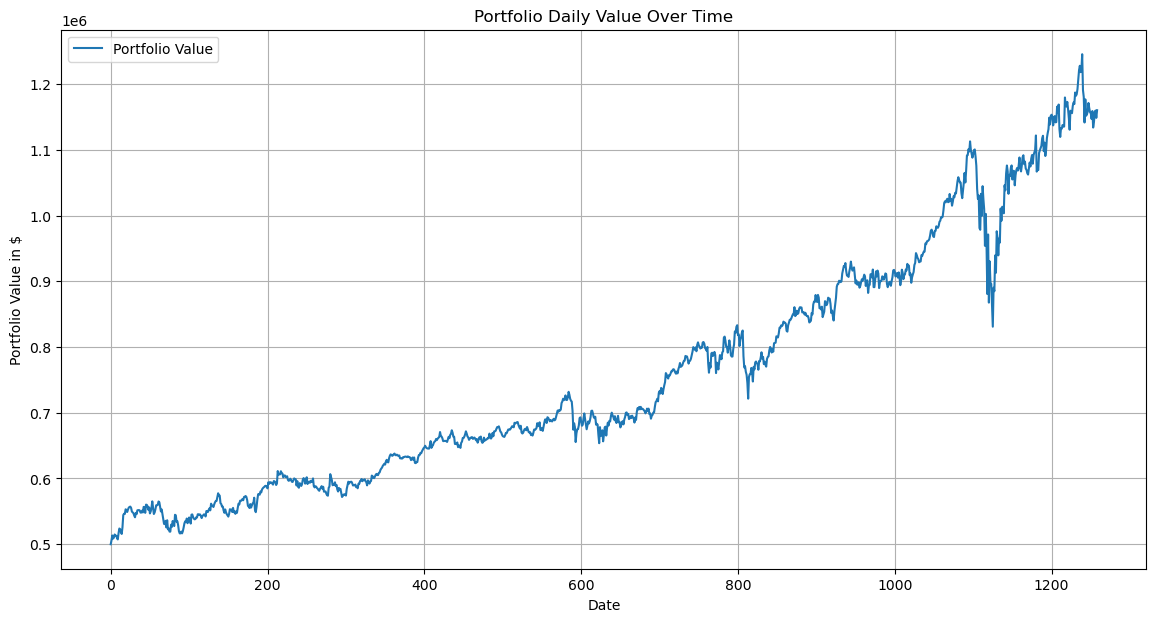

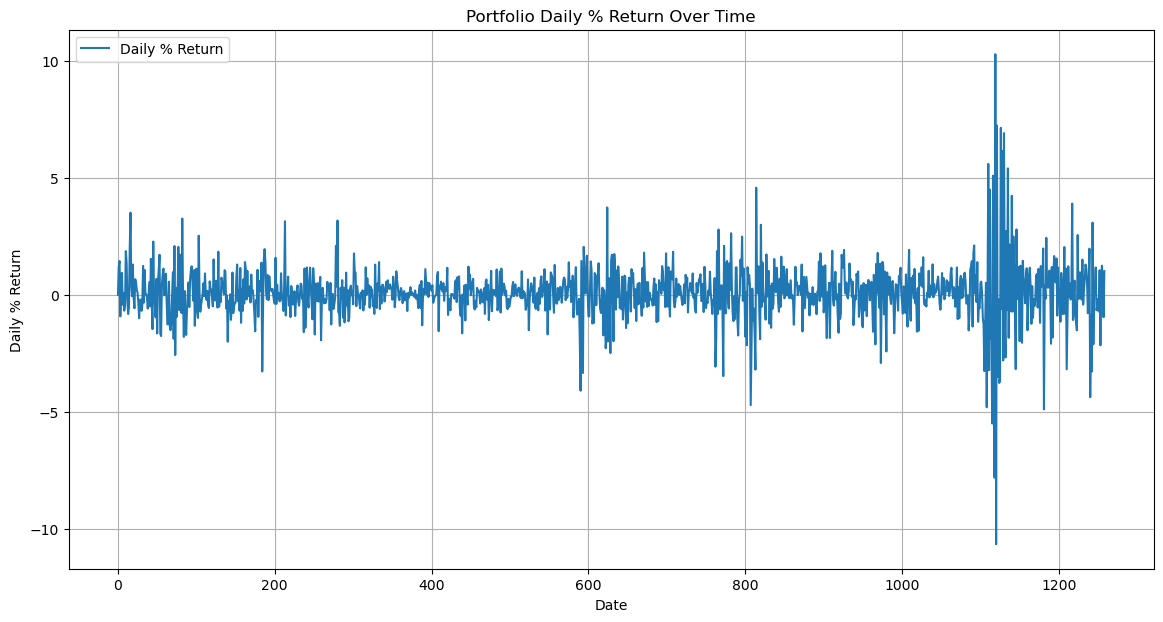

In [49]:
# Plotting the Results
plt.figure(figsize=(14, 7))
plt.plot(portn.index, portn['Portfolio Daily Value in $'], label='Portfolio Value')
plt.title('Portfolio Daily Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value in $')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(portn.index, portn['portfolio daily % return'], label='Daily % Return')
plt.title('Portfolio Daily % Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily % Return')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Peter

In [67]:
port2 = ['AMZN', 'FB', 'GOOG', 'AAPL', 'MS', 'MSFT']
weights2 = np.array([0.20, 0.20, 0.20, 0.20, 0.10, 0.10])
portn2 = portfolio_allocation(df, port2, weights2, initial_investment=1000000)
print(portn2.head())


            AMZN             FB           GOOG           AAPL             MS  \
0  200000.000000  200000.000000  200000.000000  200000.000000  100000.000000   
1  204539.870817  202462.898377  205110.502564  201460.113159   99777.777778   
2  208818.567859  206728.983180  209874.198526  202190.180690  102507.939683   
3  206437.244559  204068.182652  211173.101222  203157.503194  102730.161905   
4  208150.265856  203188.576246  210165.390606  202190.180690  104539.682540   

            MSFT  Portfolio Daily Value in $  portfolio daily % return  
0  100000.000000                1.000000e+06                  0.000000  
1  102151.981570                1.015503e+06                  1.550314  
2  104528.132604                1.034648e+06                  1.885258  
3  104797.128339                1.032363e+06                 -0.220817  
4  104909.208588                1.033143e+06                  0.075553  


In [68]:
# Calculate 5-Year Return
def calculate_5_year_return(df):
    cumulative_return = (df['Portfolio Daily Value in $'].iloc[-1] / df['Portfolio Daily Value in $'].iloc[0]) - 1
    return cumulative_return

five_year_return = calculate_5_year_return(portn2)
print(f"5-Year Cumulative Return: {five_year_return * 100:.2f}%")

5-Year Cumulative Return: 273.66%


In [69]:
# Calculate Total Portfolio Value after 5 Years
total_portfolio_value = portn2['Portfolio Daily Value in $'].iloc[-1]
print(f"Total Portfolio Value after 5 Years: ${total_portfolio_value:.2f}")

Total Portfolio Value after 5 Years: $3736576.64


In [ ]:
def portfolio_std_dev(df_portfolio):
    return df_portfolio['Portfolio Daily % Return'].std()



In [70]:
# Calculate Volatility
def calculate_volatility(df):
    daily_returns = df['portfolio daily % return'] / 100
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    return annualized_volatility

volatility = calculate_volatility(portn2)
print(f"Annualized Volatility: {volatility:.2f}")

Annualized Volatility: 0.25


In [71]:
# Calculate Sharpe Ratio
def calculate_sharpe_ratio(df, risk_free_rate=0.0075):
    daily_returns = df['portfolio daily % return'] / 100
    excess_returns = daily_returns - (risk_free_rate / 252)
    sharpe_ratio = excess_returns.mean() / daily_returns.std() * np.sqrt(252)
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(portn2)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 1.16


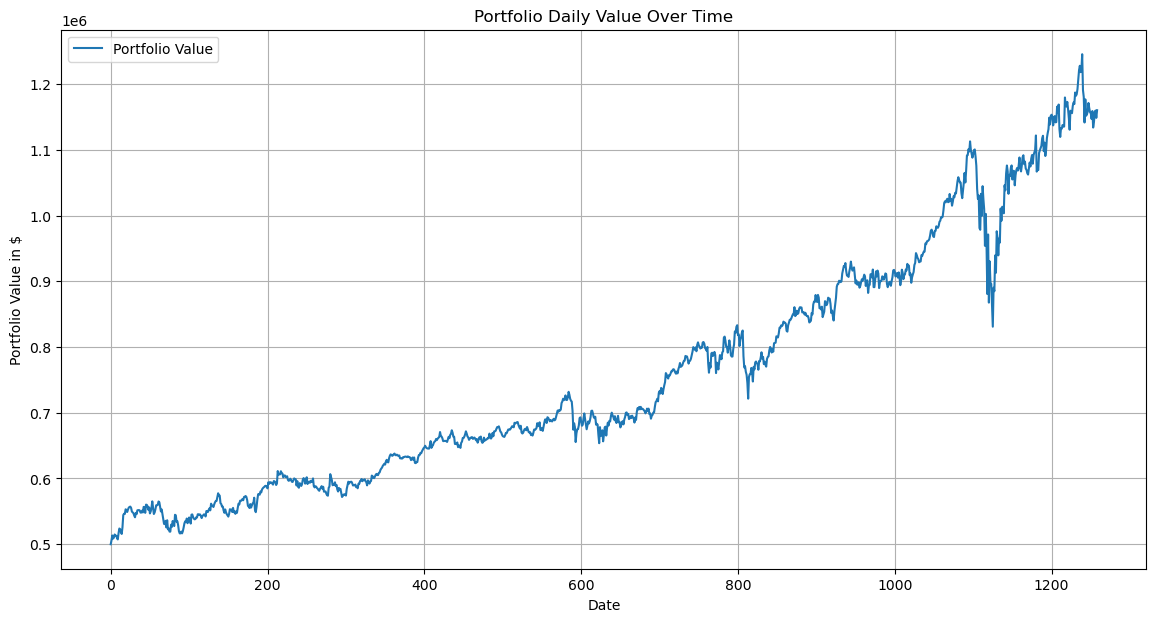

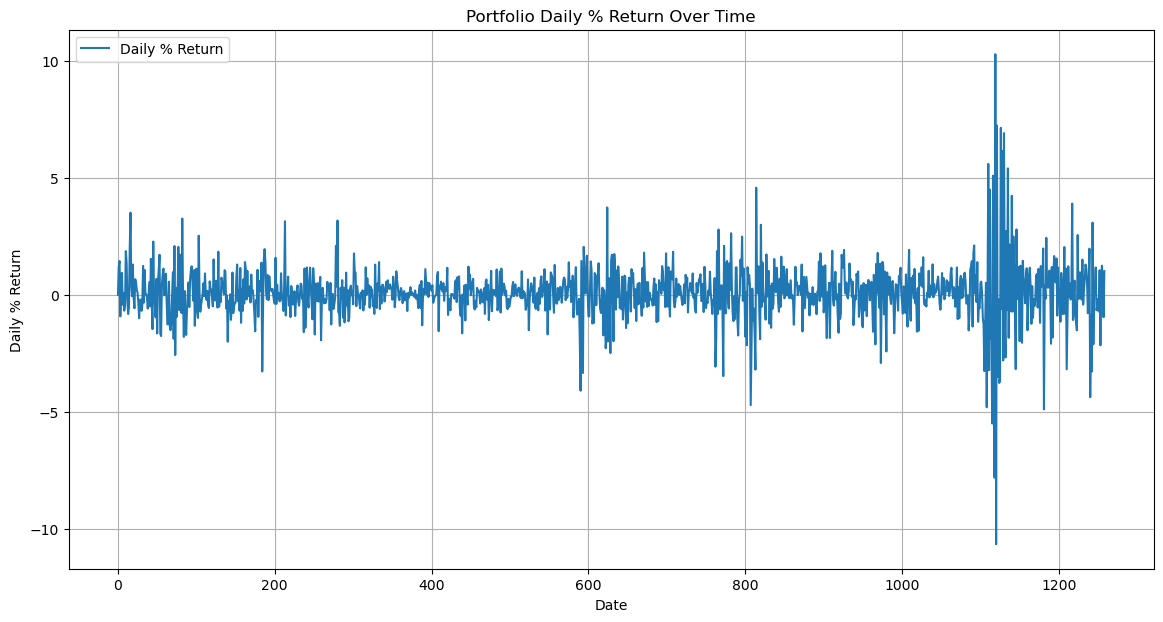

In [72]:
# Plotting the Results
plt.figure(figsize=(14, 7))
plt.plot(portn.index, portn['Portfolio Daily Value in $'], label='Portfolio Value')
plt.title('Portfolio Daily Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value in $')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(portn.index, portn['portfolio daily % return'], label='Daily % Return')
plt.title('Portfolio Daily % Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily % Return')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
#We choose the stocks that are more stable based on Corellation, Dispersion and the plots:
stocks = ['MSFT','MRK','JNJ','RHHBY']
initial_weight = np.array([0.9/4,0.8/4,1.1/4,1.2/4])

In [53]:
portfolio=df.copy()
portfolio=portfolio.set_index('Date')
portfolio=portfolio[stocks]

In [54]:
return_stocks = portfolio.pct_change()
return_stocks.tail(10)

MSFT       MRK       JNJ     RHHBY
Date                                              
2020-09-17 -0.010436  0.000818 -0.008288  0.007607
2020-09-18 -0.012419  0.001985  0.013658  0.010354
2020-09-21  0.010729 -0.031232 -0.027349 -0.011529
2020-09-22  0.024094 -0.002286 -0.006134  0.000216
2020-09-23 -0.032928 -0.003738  0.001595 -0.031311
2020-09-24  0.012962  0.006293  0.001592 -0.003567
2020-09-25  0.022787 -0.002646  0.006843  0.002685
2020-09-28  0.007795 -0.002050  0.009955 -0.015841
2020-09-29 -0.010409 -0.010391 -0.000340 -0.016776
2020-09-30  0.014812  0.012820  0.012376 -0.012912

In [55]:
#Daily Return Avg for each stock
daily_returns_portfolio_mean = return_stocks.mean()
print(daily_returns_portfolio_mean)

MSFT     0.001387
MRK      0.000511
JNJ      0.000451
RHHBY    0.000293
dtype: float64


In [56]:
#total portfolio return
allocated_daily_returns = (initial_weight * daily_returns_portfolio_mean)

portfolio_return = np.sum(allocated_daily_returns)
portfolio_return

0.0006260340597179451

In [57]:
# calculate portfolio daily returns
return_stocks['portfolio_daily_returns'] = return_stocks.dot(initial_weight)
return_stocks

MSFT       MRK       JNJ     RHHBY  portfolio_daily_returns
Date                                                                       
2015-10-01       NaN       NaN       NaN       NaN                      NaN
2015-10-02  0.021520  0.015597  0.008157  0.003010                 0.011108
2015-10-05  0.023261  0.021739  0.008836  0.003601                 0.013092
2015-10-06  0.002573 -0.027913 -0.014141  0.002691                -0.008085
2015-10-07  0.001069  0.023092  0.016699 -0.029228                 0.000683
...              ...       ...       ...       ...                      ...
2020-09-24  0.012962  0.006293  0.001592 -0.003567                 0.003543
2020-09-25  0.022787 -0.002646  0.006843  0.002685                 0.007285
2020-09-28  0.007795 -0.002050  0.009955 -0.015841                -0.000671
2020-09-29 -0.010409 -0.010391 -0.000340 -0.016776                -0.009547
2020-09-30  0.014812  0.012820  0.012376 -0.012912                 0.005427

[1259 rows x 5 columns]

In [58]:
#cumulative returns of the portfolio
Cumulative_returns_daily = (1+return_stocks).cumprod()
Cumulative_returns_daily.tail(5)

MSFT       MRK       JNJ     RHHBY  portfolio_daily_returns
Date                                                                       
2020-09-24  4.554808  1.684221  1.552753  1.345575                 2.025902
2020-09-25  4.658597  1.679765  1.563379  1.349187                 2.040661
2020-09-28  4.694911  1.676322  1.578942  1.327815                 2.039292
2020-09-29  4.646043  1.658902  1.578405  1.305539                 2.019823
2020-09-30  4.714862  1.680170  1.597939  1.288682                 2.030784

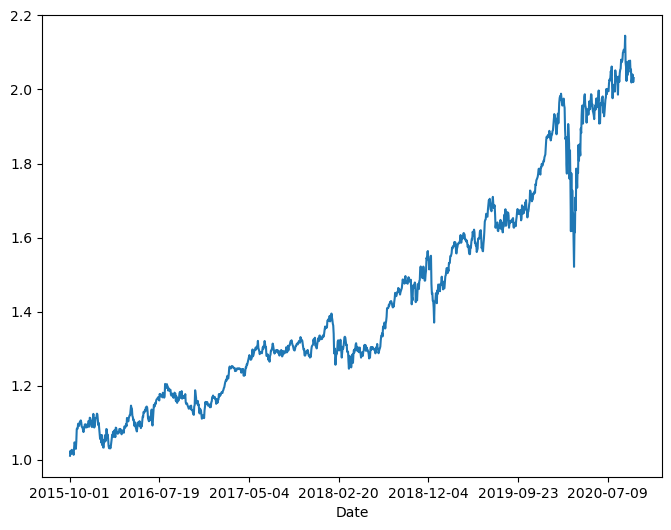

In [59]:
plt.figure(figsize=(8,6))
Cumulative_returns_daily['portfolio_daily_returns'].plot();

- The above portfolio promises a return of 103% over the next 5 years which fullfils the purpose for Mr. Patrick Jyenger.

In [60]:
#portfolio Risk
matrix_covariance_portfolio = return_stocks.iloc[:,:-1]
matrix_covariance_portfolio = (matrix_covariance_portfolio.cov())*252*5

matrix_covariance_portfolio

MSFT       MRK       JNJ     RHHBY
MSFT   0.387618  0.146870  0.141386  0.148982
MRK    0.146870  0.249327  0.129221  0.101532
JNJ    0.141386  0.129221  0.195587  0.097800
RHHBY  0.148982  0.101532  0.097800  0.230116

In [61]:
portfolio_variance = np.dot(initial_weight.T,np.dot(matrix_covariance_portfolio, initial_weight))

#standard deviation (risk of portfolio)
portfolio_risk = np.sqrt(portfolio_variance)
portfolio_risk

0.3980707906158959

- The risk associated with the above portfolio is 39.8% making it a low-risk portfolio

# Client Profile: Mr. Peter Jyenger

- Mr. Peter Jyenger is a risk-tolerant investor known for his consistent appetite for risk.

- He plans to invest 1 million dollars in high-margin stocks.

- His primary objective is to achieve very high returns over a 5-year period.

## Portfolio Details:

- We have selected stocks from Amazon, Facebook, Google, Apple, Morgan Stanley, and Microsoft, all known for their high returns but also accompanied by high risk.

- The portfolio allocation is as follows: 18.33% in Amazon, 20% in Facebook, 21.7% in Google, 11.7% in Apple, 13.3% in Morgan Stanley, and 15% in Microsoft.

- This allocation strategy aims to maximize potential returns while considering the higher risk associated with these stocks.

In [62]:
#We choose the stocks that have highest return 
stocks = ['AMZN','FB','GOOG','AAPL','MS','MSFT']
initial_weight = np.array([1.1/6,1.2/6,1.3/6,0.7/6,0.8/6,0.9/6])

In [63]:
portfolio=df.copy()
portfolio=portfolio.set_index('Date')
portfolio=portfolio[stocks]

In [64]:
return_stocks = portfolio.pct_change()
return_stocks.tail(10)

AMZN        FB      GOOG      AAPL        MS      MSFT
Date                                                                  
2020-09-17 -0.022537 -0.033015 -0.016681 -0.015964 -0.017595 -0.010436
2020-09-18 -0.017888 -0.008987 -0.023764 -0.031720 -0.003383 -0.012419
2020-09-21  0.001882 -0.017344 -0.019747  0.030326 -0.034345  0.010729
2020-09-22  0.056923  0.026597  0.023967  0.015716 -0.015095  0.024094
2020-09-23 -0.041269 -0.022493 -0.034290 -0.041946 -0.025404 -0.032928
2020-09-24  0.006644  0.002048  0.009242  0.010269  0.004093  0.012962
2020-09-25  0.024949  0.021200  0.011671  0.037516  0.009225  0.022787
2020-09-28  0.025498  0.007849  0.013537  0.023869  0.028486  0.007795
2020-09-29 -0.009190  0.019352  0.003284 -0.007568 -0.023563 -0.010409
2020-09-30  0.001224  0.000420  0.000184  0.015076  0.023497  0.014812

In [65]:
#Daily Return Avg for each stock
daily_returns_portfolio_mean = return_stocks.mean()
print(daily_returns_portfolio_mean)

AMZN    0.001611
FB      0.001050
GOOG    0.000834
AAPL    0.001322
MS      0.000578
MSFT    0.001387
dtype: float64


In [66]:
#total portfolio return
allocated_daily_returns = (initial_weight * daily_returns_portfolio_mean)

portfolio_return = np.sum(allocated_daily_returns)
portfolio_return

0.00112523713880419

In [67]:
# calculate portfolio daily returns
return_stocks['portfolio_daily_returns'] = return_stocks.dot(initial_weight)
return_stocks

AMZN        FB      GOOG      AAPL        MS      MSFT  \
Date                                                                     
2015-10-01       NaN       NaN       NaN       NaN       NaN       NaN   
2015-10-02  0.022699  0.012314  0.025553  0.007301 -0.002222  0.021520   
2015-10-05  0.020919  0.021071  0.023225  0.003624  0.027362  0.023261   
2015-10-06 -0.011404 -0.012871  0.006189  0.004784  0.002168  0.002573   
2015-10-07  0.008298 -0.004310 -0.004772 -0.004761  0.017614  0.001069   
...              ...       ...       ...       ...       ...       ...   
2020-09-24  0.006644  0.002048  0.009242  0.010269  0.004093  0.012962   
2020-09-25  0.024949  0.021200  0.011671  0.037516  0.009225  0.022787   
2020-09-28  0.025498  0.007849  0.013537  0.023869  0.028486  0.007795   
2020-09-29 -0.009190  0.019352  0.003284 -0.007568 -0.023563 -0.010409   
2020-09-30  0.001224  0.000420  0.000184  0.015076  0.023497  0.014812   

            portfolio_daily_returns  
Date                                 
2015-10-01                      NaN  
2015-10-02                 0.015944  
2015-10-05                 0.020642  
2015-10-06                -0.002091  
2015-10-07                 0.001579  
...                             ...  
2020-09-24                 0.007318  
2020-09-25                 0.020368  
2020-09-28                 0.016930  
2020-09-29                -0.002689  
2020-09-30                 0.007462  

[1259 rows x 7 columns]

In [68]:
#cumulative returns of the portfolio
Cumulative_returns_daily = (1+return_stocks).cumprod()
Cumulative_returns_daily.tail(5)

AMZN        FB      GOOG      AAPL        MS      MSFT  \
Date                                                                     
2020-09-24  5.799259  2.743595  2.336518  3.950356  1.479683  4.554808   
2020-09-25  5.943943  2.801759  2.363788  4.098558  1.493333  4.658597   
2020-09-28  6.095503  2.823749  2.395786  4.196386  1.535873  4.694911   
2020-09-29  6.039484  2.878395  2.403655  4.164628  1.499683  4.646043   
2020-09-30  6.046878  2.879604  2.404096  4.227414  1.534921  4.714862   

            portfolio_daily_returns  
Date                                 
2020-09-24                 3.394295  
2020-09-25                 3.463429  
2020-09-28                 3.522063  
2020-09-29                 3.512593  
2020-09-30                 3.538803

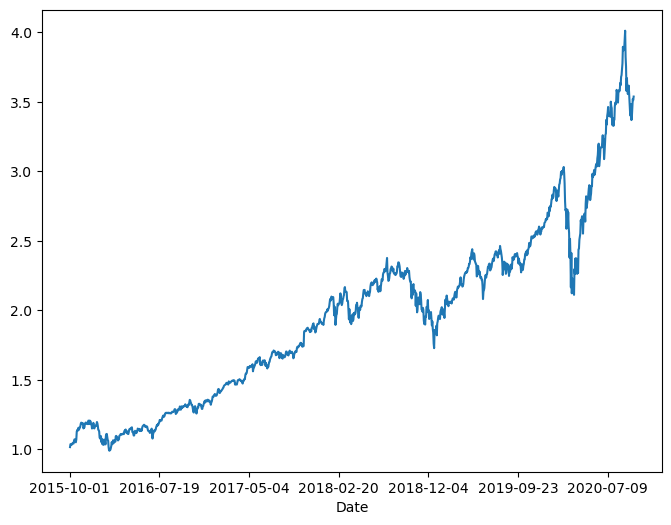

In [69]:
plt.figure(figsize=(8,6))
Cumulative_returns_daily['portfolio_daily_returns'].plot();

- The above portfolio promises a return of 250% over the next 5 years which fullfils the purpose for Mr. Peter Jyenger.

In [71]:
#Portfolio Risk
matrix_covariance_portfolio = return_stocks.iloc[:,:-1]
matrix_covariance_portfolio = (matrix_covariance_portfolio.cov())*252*5

matrix_covariance_portfolio

AMZN        FB      GOOG      AAPL        MS      MSFT
AMZN  0.453356  0.301423  0.269533  0.257986  0.201473  0.283129
FB    0.301423  0.522010  0.293674  0.271396  0.245121  0.279961
GOOG  0.269533  0.293674  0.343883  0.255345  0.249469  0.285552
AAPL  0.257986  0.271396  0.255345  0.441988  0.284439  0.291752
MS    0.201473  0.245121  0.249469  0.284439  0.599325  0.286097
MSFT  0.283129  0.279961  0.285552  0.291752  0.286097  0.387618

In [72]:
portfolio_variance = np.dot(initial_weight.T,np.dot(matrix_covariance_portfolio, initial_weight))

#standard deviation (risk of portfolio)
portfolio_risk = np.sqrt(portfolio_variance)
portfolio_risk

0.5495494450789262

- The risk associated with the above portfolio is 54.9% making it a high-risk portfolio